In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns


Define HyperParameter Tuning Method

In [13]:
def grid_tune_hyperparameters(model, param_grid, X_train, y_train):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #using grid search with cross validation
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

def random_tune_hyperparameters(model, param_grid, X_train, y_train):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=40, scoring='neg_mean_squared_error', cv=cv, random_state=42)
    
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    
    return best_params

def polynomial_tune_hyperparameters(degrees, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    bics = {}
    
    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        
        # Fit linear regression model using scikit-learn
        model_sklearn = LinearRegression()
        model_sklearn.fit(X_train_poly, y_train)
        
        # Predict on the test set
        X_test_poly = poly.transform(X_test)
        y_pred_sklearn = model_sklearn.predict(X_test_poly)
        
        ss_eps = np.sum((y_test - y_pred_sklearn) ** 2)

        bic = len(X_train) * np.log(ss_eps) + degree * np.log(len(X_train))
        
        bics[bic] = degree
    
    best_bic = min(bics.keys())
    best_degree = bics[best_bic]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=list(bics.values()), y=list(bics.keys()), marker='o')
    plt.title("BIC Values for Different Polynomial Degrees")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("BIC")
    plt.savefig("figs/BIC_comparison_feature_scaled.png")
    plt.show()
    return best_degree

Run BIC comparison test for polynomial regression

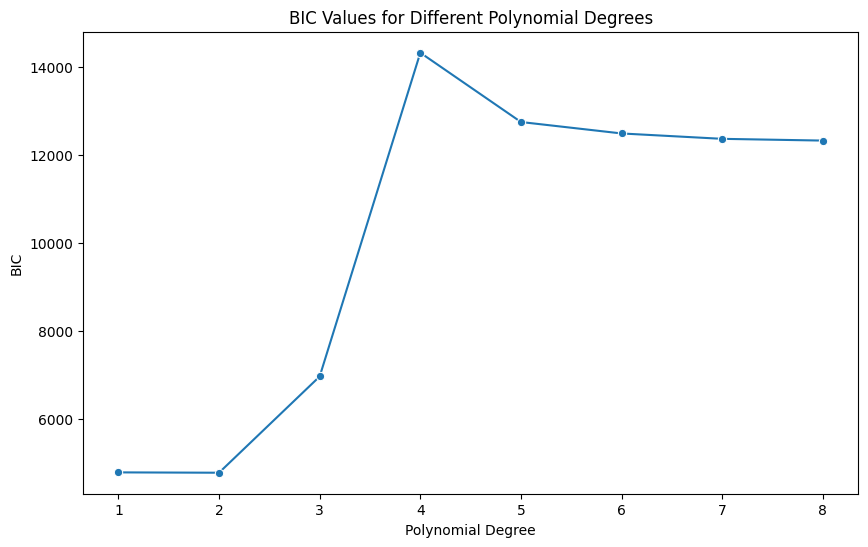

2
Mean Squared Error: 0.38185650165750096


In [14]:
df = pd.read_csv("feature_scaled_dataset.csv")

# Extract features and target
X = df.drop(columns=["quality"])
y = df['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the degree of the polynomial
degrees = range(1, 9)  # You can expand this list with more degrees to try

# Create polynomial features
poly = PolynomialFeatures()

best_degree = polynomial_tune_hyperparameters(degrees, X_train, y_train)

print(best_degree)
# Use the best degree to create polynomial features
poly = PolynomialFeatures(degree=best_degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train a linear regression model on the polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Define Method to find rough optimal hyperparameters on Degree 1

In [ ]:
def find_hyperparams(df, title):
    X = df.drop(columns=['quality'])
    y = df['quality']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #tune hyperparameters for all the models
    
    ridge_hyperparams_grid = {'alpha': uniform(loc=0.00001, scale=0.99999)}
    best_ridge_params = random_tune_hyperparameters(Ridge(), ridge_hyperparams_grid, X_train, y_train)
    print(best_ridge_params)

    lasso_hyperparams = {'alpha':  uniform(loc=0.00001, scale=0.99999)}
    best_lasso_params = random_tune_hyperparameters(Lasso(), lasso_hyperparams, X_train, y_train)
    print(best_lasso_params)

    huber_hyperparams = {'alpha': uniform(loc=0.00001, scale=0.99999), 'epsilon': uniform(loc=0.1, scale=9.9)}
    best_huber_params = random_tune_hyperparameters(HuberRegressor(max_iter=1000), huber_hyperparams, X_train, y_train)
    print(best_huber_params)
    
     # Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # Ridge Regression
    ridge_reg = Ridge(alpha=best_ridge_params['alpha'])
    ridge_reg.fit(X_train, y_train)

    # Lasso Regression
    lasso_reg = Lasso(alpha=best_lasso_params['alpha'])
    lasso_reg.fit(X_train, y_train)

    
    # Huber Regression
    Huber_reg = HuberRegressor(alpha=best_huber_params['alpha'], epsilon=best_huber_params['epsilon'],max_iter=1000)
    Huber_reg.fit(X_train, y_train)

    # Make predictions
    y_pred_lin = lin_reg.predict(X_test)
    y_pred_ridge = ridge_reg.predict(X_test)
    y_pred_lasso = lasso_reg.predict(X_test)
    y_pred_huber = Huber_reg.predict(X_test)

    # evaluation with MSE metric
    mse_lin = mean_squared_error(y_test, y_pred_lin)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    mse_huber = mean_squared_error(y_test, y_pred_huber)

    # evaluation with MAE metric
    mae_lin = mean_absolute_error(y_test, y_pred_lin)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    mae_huber = mean_absolute_error(y_test, y_pred_huber)

    # calculate largest error made by models
    max_error_lin = np.max(np.abs(y_test - y_pred_lin))
    max_error_ridge = np.max(np.abs(y_test - y_pred_ridge))
    max_error_lasso = np.max(np.abs(y_test - y_pred_lasso))
    max_error_huber = np.max(np.abs(y_test - y_pred_huber))
    
    print(f"for {title}:")

    print("\nModel Evaluations on unaltered dataset:\n")
    print("\nLinear Regression MSE:", mse_lin)
    print("Ridge Regression MSE:", mse_ridge)
    print("Lasso Regression MSE:", mse_lasso)
    print("Huber Regression MSE:", mse_huber)

    print("\nLinear Regression MAE:", mae_lin)
    print("Ridge Regression MAE:", mae_ridge)
    print("Lasso Regression MAE:", mae_lasso)
    print("Huber Regression MAE:", mae_huber)
    
    print("Largest Error made by models: \n")

    print("\nMaximum Error - Linear Regression:", max_error_lin)
    print("Maximum Error - Ridge Regression:", max_error_ridge)
    print("Maximum Error - Lasso Regression:", max_error_lasso)
    print("Maximum Error - Huber Regression:", max_error_huber)


Define Method to find rough optimal hyperparameters on Degree 2

In [ ]:
def find_hyperparams_degree_2(df, title):
    X = df.drop(columns=['quality'])
    y = df['quality']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    #tune hyperparameters for all the models
    
    ridge_hyperparams_grid = {'alpha': uniform(loc=0.00001, scale=0.99999)}
    best_ridge_params = random_tune_hyperparameters(Ridge(), ridge_hyperparams_grid, X_train_poly, y_train)

    lasso_hyperparams = {'alpha':  uniform(loc=0.00001, scale=0.99999)}
    best_lasso_params = random_tune_hyperparameters(Lasso(), lasso_hyperparams, X_train_poly, y_train)

    huber_hyperparams = {'alpha': uniform(loc=0.00001, scale=0.99999), 'epsilon': uniform(loc=0.1, scale=9.9)}
    best_huber_params = random_tune_hyperparameters(HuberRegressor(max_iter=1000), huber_hyperparams, X_train_poly, y_train)
    
    # Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_poly, y_train)
    print("\nLinear Regression Coefficients:", lin_reg.coef_)

    # Ridge Regression
    ridge_reg = Ridge(alpha=best_ridge_params['alpha'])
    ridge_reg.fit(X_train_poly, y_train)
    print("\nRidge Regression Coefficients:", ridge_reg.coef_)

    # Lasso Regression
    lasso_reg = Lasso(alpha=best_lasso_params['alpha'])
    lasso_reg.fit(X_train_poly, y_train)
    print("\nLasso Regression Coefficients:", lasso_reg.coef_)


    
    # Huber Regression
    Huber_reg = HuberRegressor(alpha=best_huber_params['alpha'], epsilon=best_huber_params['epsilon'],max_iter=1000)
    Huber_reg.fit(X_train_poly, y_train)
    print("\nHuber Regression Coefficients:", Huber_reg.coef_)


    # Make predictions
    y_pred_lin = lin_reg.predict(X_test_poly)
    y_pred_ridge = ridge_reg.predict(X_test_poly)
    y_pred_lasso = lasso_reg.predict(X_test_poly)
    y_pred_huber = Huber_reg.predict(X_test_poly)

    # evaluation with MSE metric
    mse_lin = mean_squared_error(y_test, y_pred_lin)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    mse_huber = mean_squared_error(y_test, y_pred_huber)

    # evaluation with MAE metric
    mae_lin = mean_absolute_error(y_test, y_pred_lin)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    mae_huber = mean_absolute_error(y_test, y_pred_huber)

    # calculate largest error made by models
    max_error_lin = np.max(np.abs(y_test - y_pred_lin))
    max_error_ridge = np.max(np.abs(y_test - y_pred_ridge))
    max_error_lasso = np.max(np.abs(y_test - y_pred_lasso))
    max_error_huber = np.max(np.abs(y_test - y_pred_huber))
    
    print(f"for {title}:")

    print("\nModel Evaluations on unaltered dataset:\n")
    print("\nLinear Regression MSE:", mse_lin)
    print("Ridge Regression MSE:", mse_ridge)
    print("Lasso Regression MSE:", mse_lasso)
    print("Huber Regression MSE:", mse_huber)

    print("\nLinear Regression MAE:", mae_lin)
    print("Ridge Regression MAE:", mae_ridge)
    print("Lasso Regression MAE:", mae_lasso)
    print("Huber Regression MAE:", mae_huber)
    
    print("Largest Error made by models: \n")

    print("\nMaximum Error - Linear Regression:", max_error_lin)
    print("Maximum Error - Ridge Regression:", max_error_ridge)
    print("Maximum Error - Lasso Regression:", max_error_lasso)
    print("Maximum Error - Huber Regression:", max_error_huber)


use original dataset to find rough hyperparameter ranges / performances with random CV search

In [ ]:
#df = pd.read_csv("winequality-red.csv")

#find_hyperparams(df, "Original, Unaltered Dataset")

df = pd.read_csv("feature_scaled_dataset.csv")

find_hyperparams(df, "Feature Scaled Dataset")

Define Method to Test Dataset with Multiple Regression Models with Degree 1 Regression

In [ ]:
def test_dataset_degree_1(df, title):
    X = df.drop(columns=['quality'])
    y = df['quality']


    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #tune hyperparameters for all the models
    
    ridge_hyperparams_grid = {'alpha': np.arange(0.4, 0.44, 0.001)}
    best_ridge_params = grid_tune_hyperparameters(Ridge(), ridge_hyperparams_grid, X_train, y_train)
    print(best_ridge_params)

    lasso_hyperparams = {'alpha':  np.arange(0.00001, 0.001, 0.0001 )}
    best_lasso_params = grid_tune_hyperparameters(Lasso(), lasso_hyperparams, X_train, y_train)
    print(best_lasso_params)

    huber_hyperparams = {'alpha': [0.58,0.59,0.60,0.61], 'epsilon': [6.9, 7.0, 7.1]}
    best_huber_params = grid_tune_hyperparameters(HuberRegressor(max_iter=1000), huber_hyperparams, X_train, y_train)
    print(best_huber_params)

    # Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # Ridge Regression
    ridge_reg = Ridge(alpha=best_ridge_params['alpha'])
    ridge_reg.fit(X_train, y_train)

    # Lasso Regression
    lasso_reg = Lasso(alpha=best_lasso_params['alpha'])
    lasso_reg.fit(X_train, y_train)

    
    # Huber Regression
    Huber_reg = HuberRegressor(alpha=best_huber_params['alpha'], epsilon=best_huber_params['epsilon'],max_iter=1000)
    Huber_reg.fit(X_train, y_train)

    # Make predictions
    y_pred_lin = lin_reg.predict(X_test)
    y_pred_ridge = ridge_reg.predict(X_test)
    y_pred_lasso = lasso_reg.predict(X_test)
    y_pred_huber = Huber_reg.predict(X_test)

    # evaluation with MSE metric
    mse_lin = mean_squared_error(y_test, y_pred_lin)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    mse_huber = mean_squared_error(y_test, y_pred_huber)

    # evaluation with MAE metric
    mae_lin = mean_absolute_error(y_test, y_pred_lin)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    mae_huber = mean_absolute_error(y_test, y_pred_huber)

    # calculate largest error made by models
    max_error_lin = np.max(np.abs(y_test - y_pred_lin))
    max_error_ridge = np.max(np.abs(y_test - y_pred_ridge))
    max_error_lasso = np.max(np.abs(y_test - y_pred_lasso))
    max_error_huber = np.max(np.abs(y_test - y_pred_huber))
    
    print(f"for {title}:")

    print("\nModel Evaluations on unaltered dataset:\n")
    print("\nLinear Regression MSE:", mse_lin)
    print("Ridge Regression MSE:", mse_ridge)
    print("Lasso Regression MSE:", mse_lasso)
    print("Huber Regression MSE:", mse_huber)

    print("\nLinear Regression MAE:", mae_lin)
    print("Ridge Regression MAE:", mae_ridge)
    print("Lasso Regression MAE:", mae_lasso)
    print("Huber Regression MAE:", mae_huber)
    
    print("Largest Error made by models: \n")

    print("\nMaximum Error - Linear Regression:", max_error_lin)
    print("Maximum Error - Ridge Regression:", max_error_ridge)
    print("Maximum Error - Lasso Regression:", max_error_lasso)
    print("Maximum Error - Huber Regression:", max_error_huber)

Define Method to Test Dataset with Multiple Regression Models with Degree 2 Regression

In [11]:
def test_dataset_degree_2(df, title):
    X = df.drop(columns=['quality'])
    y = df['quality']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create polynomial features
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Tune hyperparameters for all the models

    ridge_hyperparams_grid = {'alpha': np.arange(0.4, 0.44, 0.001)}
    best_ridge_params = grid_tune_hyperparameters(Ridge(), ridge_hyperparams_grid, X_train_poly, y_train)
    print(best_ridge_params)

    lasso_hyperparams = {'alpha': np.arange(0.00001, 0.001, 0.0001)}
    best_lasso_params = grid_tune_hyperparameters(Lasso(), lasso_hyperparams, X_train_poly, y_train)
    print(best_lasso_params)

    huber_hyperparams = {'alpha': [0.58, 0.59, 0.60, 0.61], 'epsilon': [6.9, 7.0, 7.1]}
    best_huber_params = grid_tune_hyperparameters(HuberRegressor(max_iter=1000), huber_hyperparams, X_train_poly, y_train)
    print(best_huber_params)

    # Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_poly, y_train)
    print("\nLinear Regression Coefficients:", lin_reg.coef_)

    # Ridge Regression
    ridge_reg = Ridge(alpha=best_ridge_params['alpha'])
    ridge_reg.fit(X_train_poly, y_train)
    print("\nRidge Regression Coefficients:", ridge_reg.coef_)

    # Lasso Regression
    lasso_reg = Lasso(alpha=best_lasso_params['alpha'])
    lasso_reg.fit(X_train_poly, y_train)
    print("\nLasso Regression Coefficients:", lasso_reg.coef_)


    
    # Huber Regression
    Huber_reg = HuberRegressor(alpha=best_huber_params['alpha'], epsilon=best_huber_params['epsilon'],max_iter=1000)
    Huber_reg.fit(X_train_poly, y_train)
    print("\nHuber Regression Coefficients:", Huber_reg.coef_)

    # Make predictions
    y_pred_lin = lin_reg.predict(X_test_poly)
    y_pred_ridge = ridge_reg.predict(X_test_poly)
    y_pred_lasso = lasso_reg.predict(X_test_poly)
    y_pred_huber = Huber_reg.predict(X_test_poly)

    # Evaluation with MSE metric
    mse_lin = mean_squared_error(y_test, y_pred_lin)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    mse_huber = mean_squared_error(y_test, y_pred_huber)

    # Evaluation with MAE metric
    mae_lin = mean_absolute_error(y_test, y_pred_lin)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    mae_huber = mean_absolute_error(y_test, y_pred_huber)

    # Calculate largest error made by models
    max_error_lin = np.max(np.abs(y_test - y_pred_lin))
    max_error_ridge = np.max(np.abs(y_test - y_pred_ridge))
    max_error_lasso = np.max(np.abs(y_test - y_pred_lasso))
    max_error_huber = np.max(np.abs(y_test - y_pred_huber))

    print(f"for {title}:")

    print("\nModel Evaluations on unaltered dataset:\n")
    print("\nLinear Regression MSE:", mse_lin)
    print("Ridge Regression MSE:", mse_ridge)
    print("Lasso Regression MSE:", mse_lasso)
    print("Huber Regression MSE:", mse_huber)

    print("\nLinear Regression MAE:", mae_lin)
    print("Ridge Regression MAE:", mae_ridge)
    print("Lasso Regression MAE:", mae_lasso)
    print("Huber Regression MAE:", mae_huber)

    print("Largest Error made by models: \n")

    print("\nMaximum Error - Linear Regression:", max_error_lin)
    print("Maximum Error - Ridge Regression:", max_error_ridge)
    print("Maximum Error - Lasso Regression:", max_error_lasso)
    print("Maximum Error - Huber Regression:", max_error_huber)

Test Models with Original Dataset

In [ ]:
df = pd.read_csv("winequality-red.csv", sep=';')

test_dataset_degree_1(df, "Original, Unaltered Dataset")

Test Models with PCA Reduced Dataset

In [ ]:
df = pd.read_csv("pca_reduced_dataset.csv")

test_dataset_degree_1(df, "PCA Reduced Dataset")

Test Models with Dataset with Composite Acidity Feature

In [ ]:
df = pd.read_csv("combined_acid_dataset.csv")

test_dataset_degree_1(df, "Composite Acidity Feature Dataset")

Test Models with Feature Scaled Dataset

In [12]:
df = pd.read_csv("feature_scaled_dataset.csv")

#test_dataset_degree_1(df, "Feature Scaled Dataset With Degree 1 Polynomial")

test_dataset_degree_2(df, "Feature Scaled Dataset With Degree 2 Polynomial")

{'alpha': 0.4}
{'alpha': 0.00031000000000000005}
{'alpha': 0.58, 'epsilon': 7.0}

Linear Regression Coefficients: [-3.04732336e-11  6.43339403e+00 -1.03956052e-01  9.75256844e-01
  2.66859047e+00 -3.68418059e-01  2.02105895e+00 -6.69494782e-01
 -7.85658140e+00  3.33378134e+00  5.08023192e+00 -2.50760912e+00
 -8.70193077e+00 -2.33348271e+00 -1.10894202e+00 -7.64688443e+00
 -1.21664394e+01 -4.65068402e+00  2.95212888e+00  1.28709902e+01
 -1.09664065e+01  2.73781701e+00  5.37723211e+00 -1.03534948e+00
  1.39891338e-01 -3.74218467e+00  3.38611269e+00 -4.37915807e+00
  9.93067948e+00  1.03318820e+00 -3.02312990e+00 -4.65094936e+00
  4.17544231e+00 -4.05998528e-01  2.24189359e-01  3.82296323e+00
  9.52779480e-01  3.75738275e-01  2.14289359e+00 -7.30897695e+00
 -3.25535323e+00  4.61220622e+00 -3.00014968e+00  1.93687172e+00
 -2.09849064e-01  3.93882108e+00  7.15140684e+00 -6.41112157e+00
 -1.85047277e+00  2.46445333e+00 -4.11026694e+00 -5.43325880e+00
  7.16163284e-02  8.84004320e+00 -4.92595